---
## 0. Imports y Configuración

In [1]:
# Imports estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings

# Redes
import igraph as ig
import networkx as nx

# Métricas de comparación de particiones
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

SEED = 42
np.random.seed(SEED)

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


In [2]:
# Rutas de datos
DATA_DIR = Path('../data/processed')

# Cargar datos
edges_bipartita = pd.read_csv(DATA_DIR / 'edges_bipartita.csv')
datos_limpios = pd.read_csv(DATA_DIR / 'datos_limpios.csv')

print(f"edges_bipartita: {edges_bipartita.shape}")
print(f"datos_limpios: {datos_limpios.shape}")
print(f"\nColumnas edges_bipartita: {edges_bipartita.columns.tolist()}")
print(f"Columnas datos_limpios: {datos_limpios.columns.tolist()}")
print(f"\nAños disponibles: {sorted(edges_bipartita['anio'].unique())}")

edges_bipartita: (7258, 3)
datos_limpios: (7955, 6)

Columnas edges_bipartita: ['persona', 'servicio', 'anio']
Columnas datos_limpios: ['AÑO', 'PERSONA', 'TIPO DE SERVICIO', 'NOMBRE DE LA TAREA', 'MODALIDAD', 'COMPLEJIDAD']

Años disponibles: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


---
## 1. Variantes de la Red

Cargamos la proyección cliente-cliente ponderada desde `proyeccion_cc_ponderada.csv` y generamos tres variantes:

1. **Ponderada**: peso = número de servicios compartidos (archivo original)
2. **No ponderada (binaria)**: todas las aristas con peso 1
3. **Jaccard normalizada**: $w_{ij}^{Jaccard} = \frac{|S_i \cap S_j|}{|S_i \cup S_j|}$

In [3]:
# Cargar proyección ponderada desde archivo existente
proyeccion = pd.read_csv(DATA_DIR / 'proyeccion_cc_ponderada.csv')

print(f"Proyección cargada desde proyeccion_cc_ponderada.csv")
print(f"Aristas: {len(proyeccion)}")
print(f"Columnas: {proyeccion.columns.tolist()}")
proyeccion.head()

Proyección cargada desde proyeccion_cc_ponderada.csv
Aristas: 7189307
Columnas: ['persona1', 'persona2', 'peso']


,persona1,persona2,peso
0,Id_5024,Id_2251,1
1,Id_5024,Id_3941,1
2,Id_5024,Id_4097,1
3,Id_5024,Id_4557,1
4,Id_5024,Id_1997,1


In [4]:
def crear_grafo_igraph(edges_df, peso_col='peso', weighted=True):
    """
    Crea un grafo igraph desde DataFrame de aristas.
    """
    # Obtener nodos únicos
    nodos = sorted(set(edges_df['persona1']) | set(edges_df['persona2']))
    nodo_a_idx = {n: i for i, n in enumerate(nodos)}
    
    # Crear aristas como tuplas de índices
    aristas = [(nodo_a_idx[r['persona1']], nodo_a_idx[r['persona2']]) 
               for _, r in edges_df.iterrows()]
    
    # Crear grafo
    g = ig.Graph(n=len(nodos), edges=aristas, directed=False)
    g.vs['name'] = nodos
    
    if weighted and peso_col in edges_df.columns:
        g.es['weight'] = edges_df[peso_col].tolist()
    else:
        g.es['weight'] = [1] * len(aristas)
    
    return g

# 1. Red ponderada (peso = servicios compartidos)
g_ponderada = crear_grafo_igraph(proyeccion, weighted=True)
print(f"Red Ponderada: {g_ponderada.vcount()} nodos, {g_ponderada.ecount()} aristas")
print(f"  - Peso min: {min(g_ponderada.es['weight'])}, max: {max(g_ponderada.es['weight'])}")

Red Ponderada: 5090 nodos, 7189307 aristas
  - Peso min: 1, max: 5


In [5]:
# 2. Red no ponderada (binaria)
g_binaria = g_ponderada.copy()
g_binaria.es['weight'] = [1] * g_binaria.ecount()
print(f"Red Binaria: {g_binaria.vcount()} nodos, {g_binaria.ecount()} aristas")

Red Binaria: 5090 nodos, 7189307 aristas


In [6]:
def calcular_peso_jaccard(df_bipartita, edges_df, persona_col='persona', servicio_col='servicio'):
    """
    Calcula peso Jaccard: |S_i ∩ S_j| / |S_i ∪ S_j|
    """
    # Conjunto de servicios por persona
    persona_servicios = df_bipartita.groupby(persona_col)[servicio_col].apply(set).to_dict()
    
    pesos_jaccard = []
    for _, row in edges_df.iterrows():
        p1, p2 = row['persona1'], row['persona2']
        s1 = persona_servicios.get(p1, set())
        s2 = persona_servicios.get(p2, set())
        
        interseccion = len(s1 & s2)
        union = len(s1 | s2)
        
        jaccard = interseccion / union if union > 0 else 0
        pesos_jaccard.append(jaccard)
    
    return pesos_jaccard

# 3. Red con peso Jaccard
proyeccion['peso_jaccard'] = calcular_peso_jaccard(edges_bipartita, proyeccion)
g_jaccard = crear_grafo_igraph(proyeccion, peso_col='peso_jaccard', weighted=True)
g_jaccard.es['weight'] = proyeccion['peso_jaccard'].tolist()

print(f"Red Jaccard: {g_jaccard.vcount()} nodos, {g_jaccard.ecount()} aristas")
print(f"  - Peso Jaccard min: {min(g_jaccard.es['weight']):.3f}, max: {max(g_jaccard.es['weight']):.3f}")

Red Jaccard: 5090 nodos, 7189307 aristas
  - Peso Jaccard min: 0.143, max: 1.000


In [7]:
# Resumen de variantes (3 variantes: Ponderada, Binaria, Jaccard)
variantes_resumen = pd.DataFrame({
    'Variante': ['Ponderada', 'Binaria', 'Jaccard'],
    'Nodos': [g_ponderada.vcount(), g_binaria.vcount(), g_jaccard.vcount()],
    'Aristas': [g_ponderada.ecount(), g_binaria.ecount(), g_jaccard.ecount()],
    'Peso_min': [
        min(g_ponderada.es['weight']),
        min(g_binaria.es['weight']),
        round(min(g_jaccard.es['weight']), 3)
    ],
    'Peso_max': [
        max(g_ponderada.es['weight']),
        max(g_binaria.es['weight']),
        round(max(g_jaccard.es['weight']), 3)
    ],
    'Peso_medio': [
        round(np.mean(g_ponderada.es['weight']), 2),
        round(np.mean(g_binaria.es['weight']), 2),
        round(np.mean(g_jaccard.es['weight']), 3)
    ]
})

print("\n=== RESUMEN DE VARIANTES DE RED ===")
variantes_resumen


=== RESUMEN DE VARIANTES DE RED ===


,Variante,Nodos,Aristas,Peso_min,Peso_max,Peso_medio
0,Ponderada,5090,7189307,1.000,5.0,1.030
1,Binaria,5090,7189307,1.000,1.0,1.000
2,Jaccard,5090,7189307,0.143,1.0,0.757


---
## 2. Detección de Comunidades

Aplicamos dos algoritmos:
- **Louvain** (multilevel community detection) – sobre la red completa
- **Girvan-Newman** (edge betweenness) – sobre un subgrafo pequeño para comparación

Usaremos la **red Jaccard** para la detección de comunidades ya que normaliza por el tamaño del portfolio de servicios.

In [8]:
# ============================================
# LOUVAIN en las 3 variantes de red
# ============================================

# 1. Louvain sobre red PONDERADA
print("Ejecutando Louvain sobre red PONDERADA...")
louvain_ponderada = g_ponderada.community_multilevel(weights='weight')
g_ponderada.vs['comunidad_louvain'] = louvain_ponderada.membership
n_com_ponderada = len(set(louvain_ponderada.membership))
mod_ponderada = louvain_ponderada.modularity
print(f"  → Comunidades: {n_com_ponderada}, Modularidad: {mod_ponderada:.4f}")

# 2. Louvain sobre red BINARIA (sin pesos)
print("\nEjecutando Louvain sobre red BINARIA...")
louvain_binaria = g_binaria.community_multilevel(weights=None)
g_binaria.vs['comunidad_louvain'] = louvain_binaria.membership
n_com_binaria = len(set(louvain_binaria.membership))
mod_binaria = louvain_binaria.modularity
print(f"  → Comunidades: {n_com_binaria}, Modularidad: {mod_binaria:.4f}")

# 3. Louvain sobre red JACCARD
print("\nEjecutando Louvain sobre red JACCARD...")
louvain_jaccard = g_jaccard.community_multilevel(weights='weight')
g_jaccard.vs['comunidad_louvain'] = louvain_jaccard.membership
n_com_jaccard = len(set(louvain_jaccard.membership))
mod_jaccard = louvain_jaccard.modularity
print(f"  → Comunidades: {n_com_jaccard}, Modularidad: {mod_jaccard:.4f}")

# Para compatibilidad con el resto del notebook
louvain_result = louvain_jaccard
n_comunidades = n_com_jaccard
modularidad = mod_jaccard

# Resumen Louvain
print("\n" + "="*60)
print("RESUMEN LOUVAIN - TODAS LAS REDES")
print("="*60)
louvain_resumen = pd.DataFrame({
    'Red': ['Ponderada', 'Binaria', 'Jaccard'],
    'Comunidades': [n_com_ponderada, n_com_binaria, n_com_jaccard],
    'Modularidad': [round(mod_ponderada, 4), round(mod_binaria, 4), round(mod_jaccard, 4)]
})
louvain_resumen

Ejecutando Louvain sobre red PONDERADA...
  → Comunidades: 3, Modularidad: 0.3038

Ejecutando Louvain sobre red BINARIA...
  → Comunidades: 4, Modularidad: 0.3024

Ejecutando Louvain sobre red JACCARD...
  → Comunidades: 3, Modularidad: 0.3826

RESUMEN LOUVAIN - TODAS LAS REDES


,Red,Comunidades,Modularidad
0,Ponderada,3,0.3038
1,Binaria,4,0.3024
2,Jaccard,3,0.3826


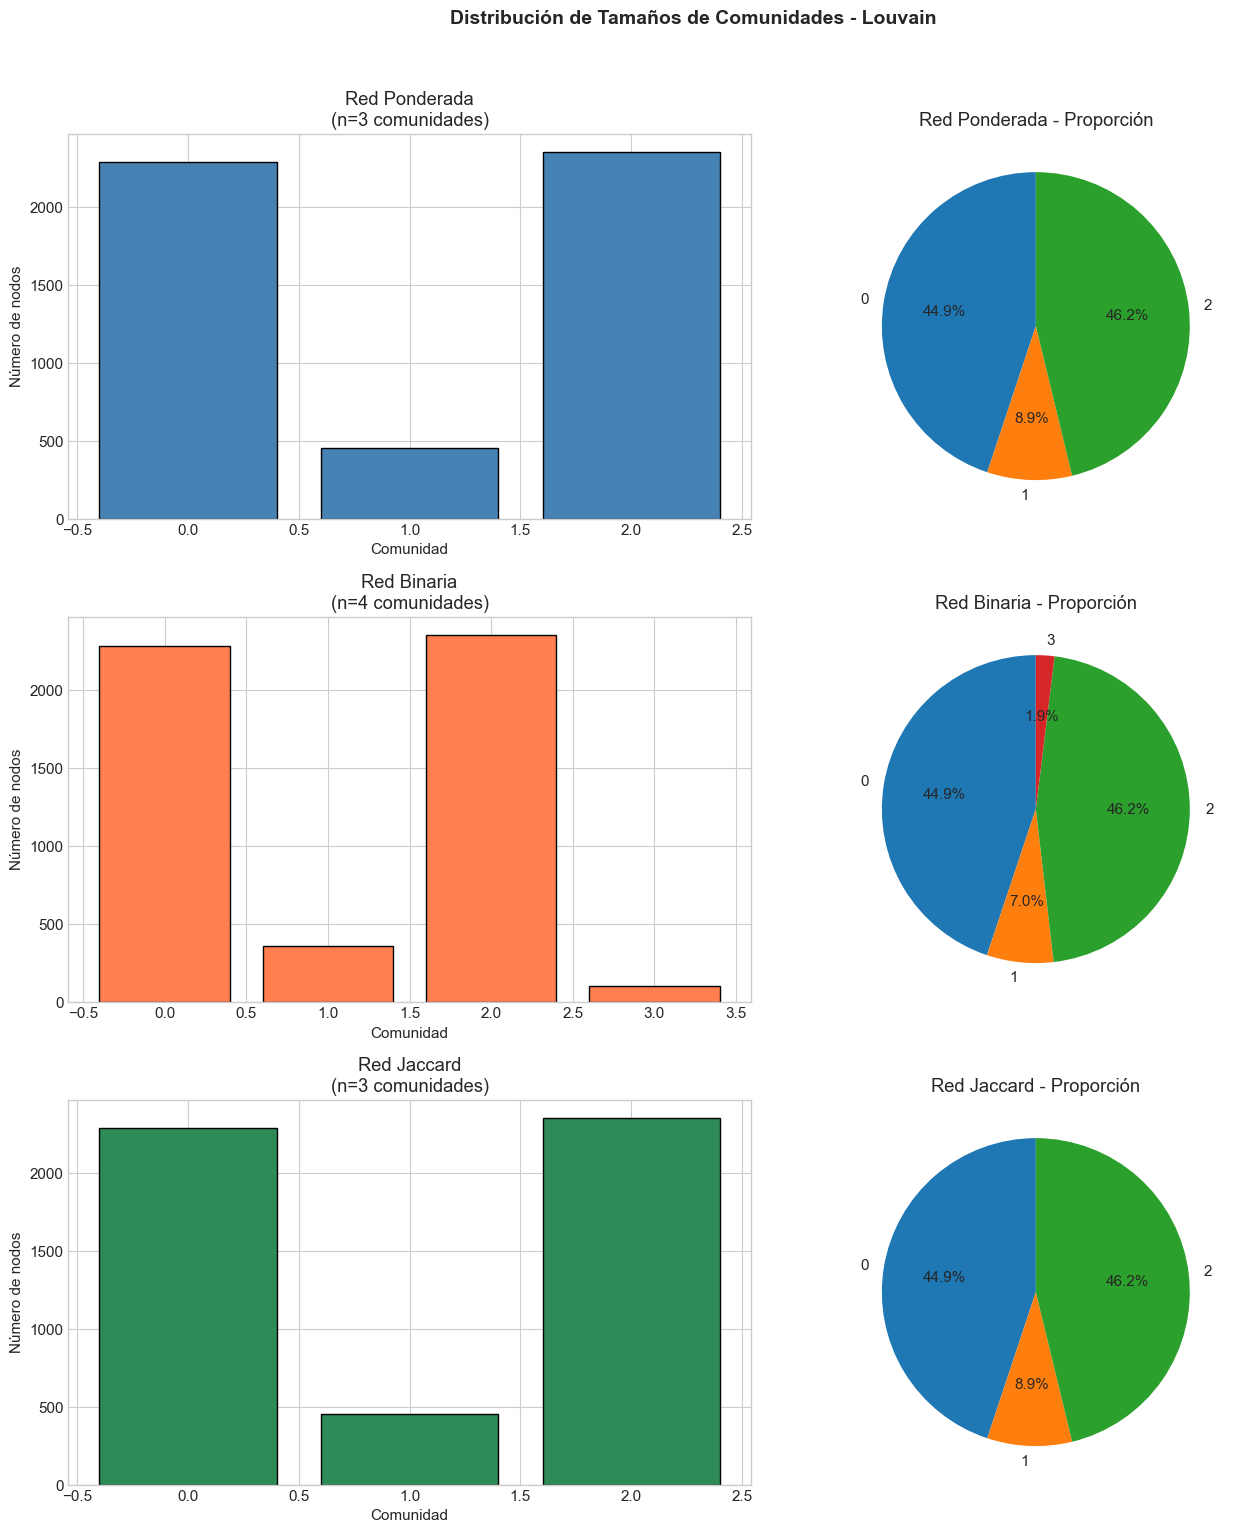


=== DISTRIBUCIÓN DE TAMAÑOS POR RED ===

Red Ponderada:
 Comunidad  Tamaño
         0    2285
         1     453
         2    2352

Red Binaria:
 Comunidad  Tamaño
         0    2283
         1     356
         2    2352
         3      99

Red Jaccard:
 Comunidad  Tamaño
         0    2285
         1     453
         2    2352


In [9]:
# ============================================
# DISTRIBUCIÓN DE TAMAÑOS - LOUVAIN EN LAS 3 REDES
# ============================================

def graficar_distribucion_comunidades(louvain_result, nombre_red, ax_bar, ax_pie, color='steelblue'):
    """Grafica la distribución de tamaños de comunidades."""
    tamaños = Counter(louvain_result.membership)
    tamaños_df = pd.DataFrame([{'Comunidad': k, 'Tamaño': v} for k, v in sorted(tamaños.items())])
    n_com = len(tamaños_df)
    
    # Barras
    ax_bar.bar(tamaños_df['Comunidad'], tamaños_df['Tamaño'], color=color, edgecolor='black')
    ax_bar.set_xlabel('Comunidad')
    ax_bar.set_ylabel('Número de nodos')
    ax_bar.set_title(f'{nombre_red}\n(n={n_com} comunidades)')
    
    # Pie o histograma
    if n_com <= 10:
        ax_pie.pie(tamaños_df['Tamaño'], labels=tamaños_df['Comunidad'], autopct='%1.1f%%', startangle=90)
        ax_pie.set_title(f'{nombre_red} - Proporción')
    else:
        ax_pie.hist(tamaños_df['Tamaño'], bins=min(20, n_com), color=color, edgecolor='black')
        ax_pie.set_xlabel('Tamaño de comunidad')
        ax_pie.set_ylabel('Frecuencia')
        ax_pie.set_title(f'{nombre_red} - Distribución')
    
    return tamaños_df

# Crear figura con 3 filas (una por red) x 2 columnas (barras + pie/hist)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Red Ponderada
tamaños_ponderada = graficar_distribucion_comunidades(louvain_ponderada, "Red Ponderada", 
                                                       axes[0, 0], axes[0, 1], color='steelblue')
# Red Binaria
tamaños_binaria = graficar_distribucion_comunidades(louvain_binaria, "Red Binaria", 
                                                     axes[1, 0], axes[1, 1], color='coral')
# Red Jaccard
tamaños_jaccard = graficar_distribucion_comunidades(louvain_jaccard, "Red Jaccard", 
                                                     axes[2, 0], axes[2, 1], color='seagreen')

plt.suptitle('Distribución de Tamaños de Comunidades - Louvain', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/comunidades_louvain_distribucion_todas.png', dpi=150, bbox_inches='tight')
plt.show()

# Para compatibilidad
tamaños_comunidades = Counter(louvain_result.membership)
tamaños_df = pd.DataFrame([{'Comunidad': k, 'Tamaño': v} for k, v in sorted(tamaños_comunidades.items())])

# Mostrar resumen tabular
print("\n=== DISTRIBUCIÓN DE TAMAÑOS POR RED ===")
print("\nRed Ponderada:")
print(tamaños_ponderada.to_string(index=False))
print(f"\nRed Binaria:")
print(tamaños_binaria.to_string(index=False))
print(f"\nRed Jaccard:")
print(tamaños_jaccard.to_string(index=False))

In [10]:
# ============================================
# GIRVAN-NEWMAN en subgrafos de las 3 redes
# ============================================
print("Ejecutando Girvan-Newman sobre subgrafos (computacionalmente costoso)...\n")

def aplicar_girvan_newman(g, nombre_red, n_nodos_muestra=100):
    """Aplica Girvan-Newman a un subgrafo."""
    if g.vcount() > n_nodos_muestra:
        np.random.seed(SEED)
        nodos_muestra = np.random.choice(g.vcount(), size=min(n_nodos_muestra, g.vcount()), replace=False)
        g_sub = g.subgraph(nodos_muestra)
    else:
        g_sub = g.copy()
    
    print(f"{nombre_red}: Subgrafo con {g_sub.vcount()} nodos, {g_sub.ecount()} aristas")
    
    if g_sub.ecount() > 0:
        gn_result = g_sub.community_edge_betweenness(weights='weight' if nombre_red != 'Binaria' else None)
        gn_clusters = gn_result.as_clustering()
        n_com = len(set(gn_clusters.membership))
        mod = gn_clusters.modularity
        print(f"  → Comunidades: {n_com}, Modularidad: {mod:.4f}")
        return n_com, mod, g_sub
    else:
        print(f"  → Sin aristas")
        return 0, np.nan, g_sub

# Aplicar a las 3 redes
n_gn_ponderada, mod_gn_ponderada, g_sub_ponderada = aplicar_girvan_newman(g_ponderada, "Ponderada")
n_gn_binaria, mod_gn_binaria, g_sub_binaria = aplicar_girvan_newman(g_binaria, "Binaria")
n_gn_jaccard, mod_gn_jaccard, g_sub_jaccard = aplicar_girvan_newman(g_jaccard, "Jaccard")

# Para compatibilidad
g_subgrafo = g_sub_jaccard
n_comunidades_gn = n_gn_jaccard
modularidad_gn = mod_gn_jaccard

# Resumen Girvan-Newman
print("\n" + "="*60)
print("RESUMEN GIRVAN-NEWMAN - TODAS LAS REDES (Subgrafos)")
print("="*60)
gn_resumen = pd.DataFrame({
    'Red': ['Ponderada', 'Binaria', 'Jaccard'],
    'Comunidades': [n_gn_ponderada, n_gn_binaria, n_gn_jaccard],
    'Modularidad': [round(mod_gn_ponderada, 4) if not np.isnan(mod_gn_ponderada) else np.nan,
                    round(mod_gn_binaria, 4) if not np.isnan(mod_gn_binaria) else np.nan,
                    round(mod_gn_jaccard, 4) if not np.isnan(mod_gn_jaccard) else np.nan]
})
gn_resumen

Ejecutando Girvan-Newman sobre subgrafos (computacionalmente costoso)...

Ponderada: Subgrafo con 100 nodos, 2988 aristas
  → Comunidades: 5, Modularidad: 0.2550
Binaria: Subgrafo con 100 nodos, 2988 aristas
  → Comunidades: 8, Modularidad: 0.2595
Jaccard: Subgrafo con 100 nodos, 2988 aristas
  → Comunidades: 4, Modularidad: 0.3533

RESUMEN GIRVAN-NEWMAN - TODAS LAS REDES (Subgrafos)


,Red,Comunidades,Modularidad
0,Ponderada,5,0.2550
1,Binaria,8,0.2595
2,Jaccard,4,0.3533


In [11]:
# ============================================
# COMPARACIÓN COMPLETA DE ALGORITMOS Y REDES
# ============================================

comparacion_completa = pd.DataFrame({
    'Algoritmo': ['Louvain', 'Louvain', 'Louvain', 'Girvan-Newman', 'Girvan-Newman', 'Girvan-Newman'],
    'Red': ['Ponderada', 'Binaria', 'Jaccard', 'Ponderada (sub)', 'Binaria (sub)', 'Jaccard (sub)'],
    'Comunidades': [n_com_ponderada, n_com_binaria, n_com_jaccard, n_gn_ponderada, n_gn_binaria, n_gn_jaccard],
    'Modularidad': [
        round(mod_ponderada, 4), round(mod_binaria, 4), round(mod_jaccard, 4),
        round(mod_gn_ponderada, 4) if not np.isnan(mod_gn_ponderada) else np.nan,
        round(mod_gn_binaria, 4) if not np.isnan(mod_gn_binaria) else np.nan,
        round(mod_gn_jaccard, 4) if not np.isnan(mod_gn_jaccard) else np.nan
    ]
})

print("\n=== COMPARACIÓN COMPLETA: ALGORITMOS × REDES ===")
comparacion_completa


=== COMPARACIÓN COMPLETA: ALGORITMOS × REDES ===


,Algoritmo,Red,Comunidades,Modularidad
0,Louvain,Ponderada,3,0.3038
1,Louvain,Binaria,4,0.3024
2,Louvain,Jaccard,3,0.3826
3,Girvan-Newman,Ponderada (sub),5,0.2550
4,Girvan-Newman,Binaria (sub),8,0.2595
5,Girvan-Newman,Jaccard (sub),4,0.3533


In [12]:
# ============================================
# COMPARACIÓN DE PARTICIONES LOUVAIN ENTRE REDES
# ============================================

def calcular_similaridad_particiones_redes(g1, membership1, g2, membership2):
    """
    Calcula ARI y NMI entre dos particiones de diferentes redes.
    Solo considera nodos comunes entre ambas redes.
    """
    nodos1 = set(g1.vs['name'])
    nodos2 = set(g2.vs['name'])
    nodos_comunes = nodos1 & nodos2
    
    if len(nodos_comunes) < 2:
        return np.nan, np.nan, 0
    
    # Mapear membresía para nodos comunes
    memb1 = {n: m for n, m in zip(g1.vs['name'], membership1)}
    memb2 = {n: m for n, m in zip(g2.vs['name'], membership2)}
    
    nodos_lista = sorted(nodos_comunes)
    labels1 = [memb1[n] for n in nodos_lista]
    labels2 = [memb2[n] for n in nodos_lista]
    
    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)
    
    return ari, nmi, len(nodos_comunes)

# Comparar las 3 redes entre sí
comparaciones_redes = []

# Ponderada vs Binaria
ari_pb, nmi_pb, n_pb = calcular_similaridad_particiones_redes(
    g_ponderada, louvain_ponderada.membership,
    g_binaria, louvain_binaria.membership
)
comparaciones_redes.append({'Comparación': 'Ponderada vs Binaria', 'Nodos_comunes': n_pb, 'ARI': round(ari_pb, 4), 'NMI': round(nmi_pb, 4)})

# Ponderada vs Jaccard
ari_pj, nmi_pj, n_pj = calcular_similaridad_particiones_redes(
    g_ponderada, louvain_ponderada.membership,
    g_jaccard, louvain_jaccard.membership
)
comparaciones_redes.append({'Comparación': 'Ponderada vs Jaccard', 'Nodos_comunes': n_pj, 'ARI': round(ari_pj, 4), 'NMI': round(nmi_pj, 4)})

# Binaria vs Jaccard
ari_bj, nmi_bj, n_bj = calcular_similaridad_particiones_redes(
    g_binaria, louvain_binaria.membership,
    g_jaccard, louvain_jaccard.membership
)
comparaciones_redes.append({'Comparación': 'Binaria vs Jaccard', 'Nodos_comunes': n_bj, 'ARI': round(ari_bj, 4), 'NMI': round(nmi_bj, 4)})

comparaciones_redes_df = pd.DataFrame(comparaciones_redes)

print("\n=== SIMILARIDAD ENTRE PARTICIONES LOUVAIN (ARI/NMI) ===")
print("Comparación de las comunidades detectadas en las 3 variantes de red\n")
display(comparaciones_redes_df)

# Interpretación
print("\nInterpretación:")
print("- ARI/NMI cercano a 1: Las particiones son muy similares")
print("- ARI/NMI cercano a 0: Las particiones son muy diferentes")
print(f"\nLa mayor similitud es entre: {comparaciones_redes_df.loc[comparaciones_redes_df['ARI'].idxmax(), 'Comparación']}")
print(f"La menor similitud es entre: {comparaciones_redes_df.loc[comparaciones_redes_df['ARI'].idxmin(), 'Comparación']}")


=== SIMILARIDAD ENTRE PARTICIONES LOUVAIN (ARI/NMI) ===
Comparación de las comunidades detectadas en las 3 variantes de red



,Comparación,Nodos_comunes,ARI,NMI
0,Ponderada vs Binaria,5090,0.9938,0.9731
1,Ponderada vs Jaccard,5090,1.0000,1.0000
2,Binaria vs Jaccard,5090,0.9938,0.9731



Interpretación:
- ARI/NMI cercano a 1: Las particiones son muy similares
- ARI/NMI cercano a 0: Las particiones son muy diferentes

La mayor similitud es entre: Ponderada vs Jaccard
La menor similitud es entre: Ponderada vs Binaria


---
## 3. Análisis Temporal

Construimos redes por año y comparamos las particiones usando:
- **ARI** (Adjusted Rand Index)
- **NMI** (Normalized Mutual Information)

In [13]:
from itertools import combinations

def construir_proyeccion_ponderada(df_bipartita, persona_col='persona', servicio_col='servicio'):
    """
    Construye la proyección unimodal de personas conectadas por servicios compartidos.
    Peso = número de servicios en común.
    """
    servicio_personas = df_bipartita.groupby(servicio_col)[persona_col].apply(set).to_dict()
    edge_counts = Counter()
    
    for servicio, personas in servicio_personas.items():
        for p1, p2 in combinations(sorted(personas), 2):
            edge_counts[(p1, p2)] += 1
    
    edges_df = pd.DataFrame([
        {'persona1': p1, 'persona2': p2, 'peso': count}
        for (p1, p2), count in edge_counts.items()
    ])
    return edges_df

def construir_red_anual(df_bipartita, anio):
    """
    Construye la proyección para un año específico.
    """
    df_anio = df_bipartita[df_bipartita['anio'] == anio]
    if len(df_anio) == 0:
        return None, None
    
    proyeccion_anio = construir_proyeccion_ponderada(df_anio)
    if len(proyeccion_anio) == 0:
        return None, None
        
    # Calcular Jaccard
    proyeccion_anio['peso_jaccard'] = calcular_peso_jaccard(df_anio, proyeccion_anio)
    g_anio = crear_grafo_igraph(proyeccion_anio, peso_col='peso_jaccard', weighted=True)
    g_anio.es['weight'] = proyeccion_anio['peso_jaccard'].tolist()
    
    return g_anio, proyeccion_anio

# Construir redes anuales
anios = sorted(edges_bipartita['anio'].unique())
redes_anuales = {}
comunidades_anuales = {}

print("Construyendo redes anuales...")
for anio in anios:
    g_anio, proy_anio = construir_red_anual(edges_bipartita, anio)
    if g_anio is not None and g_anio.vcount() > 0 and g_anio.ecount() > 0:
        redes_anuales[anio] = g_anio
        # Detectar comunidades
        louvain_anio = g_anio.community_multilevel(weights='weight')
        comunidades_anuales[anio] = {
            'particion': louvain_anio,
            'n_comunidades': len(set(louvain_anio.membership)),
            'modularidad': louvain_anio.modularity,
            'nodos': g_anio.vs['name'],
            'membership': louvain_anio.membership
        }
        print(f"  {anio}: {g_anio.vcount()} nodos, {g_anio.ecount()} aristas, {comunidades_anuales[anio]['n_comunidades']} comunidades")
    else:
        print(f"  {anio}: Sin datos suficientes")

Construyendo redes anuales...
  2019: 298 nodos, 44253 aristas, 1 comunidades
  2019: 298 nodos, 44253 aristas, 1 comunidades
  2020: 806 nodos, 207212 aristas, 3 comunidades
  2020: 806 nodos, 207212 aristas, 3 comunidades
  2021: 2386 nodos, 1629741 aristas, 3 comunidades
  2021: 2386 nodos, 1629741 aristas, 3 comunidades
  2022: 1557 nodos, 601274 aristas, 5 comunidades
  2022: 1557 nodos, 601274 aristas, 5 comunidades
  2023: 711 nodos, 152168 aristas, 4 comunidades
  2023: 711 nodos, 152168 aristas, 4 comunidades
  2024: 375 nodos, 30630 aristas, 5 comunidades
  2024: 375 nodos, 30630 aristas, 5 comunidades


In [14]:
# Resumen de redes anuales
redes_anuales_df = pd.DataFrame([
    {
        'Año': anio,
        'Nodos': redes_anuales[anio].vcount(),
        'Aristas': redes_anuales[anio].ecount(),
        'Comunidades': comunidades_anuales[anio]['n_comunidades'],
        'Modularidad': round(comunidades_anuales[anio]['modularidad'], 4)
    }
    for anio in sorted(redes_anuales.keys())
])

print("\n=== RESUMEN DE REDES ANUALES ===")
redes_anuales_df


=== RESUMEN DE REDES ANUALES ===


,Año,Nodos,Aristas,Comunidades,Modularidad
0,2019,298,44253,1,0.0000
1,2020,806,207212,3,0.1936
2,2021,2386,1629741,3,0.3062
3,2022,1557,601274,5,0.3204
4,2023,711,152168,4,0.3382
5,2024,375,30630,5,0.4024


In [15]:
def calcular_similaridad_particiones(com1, com2):
    """
    Calcula ARI y NMI entre dos particiones.
    Solo considera nodos comunes entre ambos años.
    """
    nodos1 = set(com1['nodos'])
    nodos2 = set(com2['nodos'])
    nodos_comunes = nodos1 & nodos2
    
    if len(nodos_comunes) < 2:
        return np.nan, np.nan, 0
    
    # Mapear membresía para nodos comunes
    memb1 = {n: m for n, m in zip(com1['nodos'], com1['membership'])}
    memb2 = {n: m for n, m in zip(com2['nodos'], com2['membership'])}
    
    nodos_lista = sorted(nodos_comunes)
    labels1 = [memb1[n] for n in nodos_lista]
    labels2 = [memb2[n] for n in nodos_lista]
    
    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)
    
    return ari, nmi, len(nodos_comunes)

# Calcular ARI/NMI entre años consecutivos
anios_ordenados = sorted(comunidades_anuales.keys())
comparaciones = []

print("\nComparando particiones entre años consecutivos...")
for i in range(len(anios_ordenados) - 1):
    anio1 = anios_ordenados[i]
    anio2 = anios_ordenados[i + 1]
    
    ari, nmi, n_comunes = calcular_similaridad_particiones(
        comunidades_anuales[anio1],
        comunidades_anuales[anio2]
    )
    
    comparaciones.append({
        'Años': f"{anio1}-{anio2}",
        'Nodos_comunes': n_comunes,
        'ARI': round(ari, 4) if not np.isnan(ari) else np.nan,
        'NMI': round(nmi, 4) if not np.isnan(nmi) else np.nan
    })

comparaciones_df = pd.DataFrame(comparaciones)
print("\n=== ESTABILIDAD TEMPORAL (ARI/NMI) ===")
comparaciones_df


Comparando particiones entre años consecutivos...

=== ESTABILIDAD TEMPORAL (ARI/NMI) ===


,Años,Nodos_comunes,ARI,NMI
0,2019-2020,43,0.0000,0.0000
1,2020-2021,185,0.0050,0.0100
2,2021-2022,289,-0.0268,0.0184
3,2022-2023,227,0.1259,0.1269
4,2023-2024,117,0.1394,0.1485


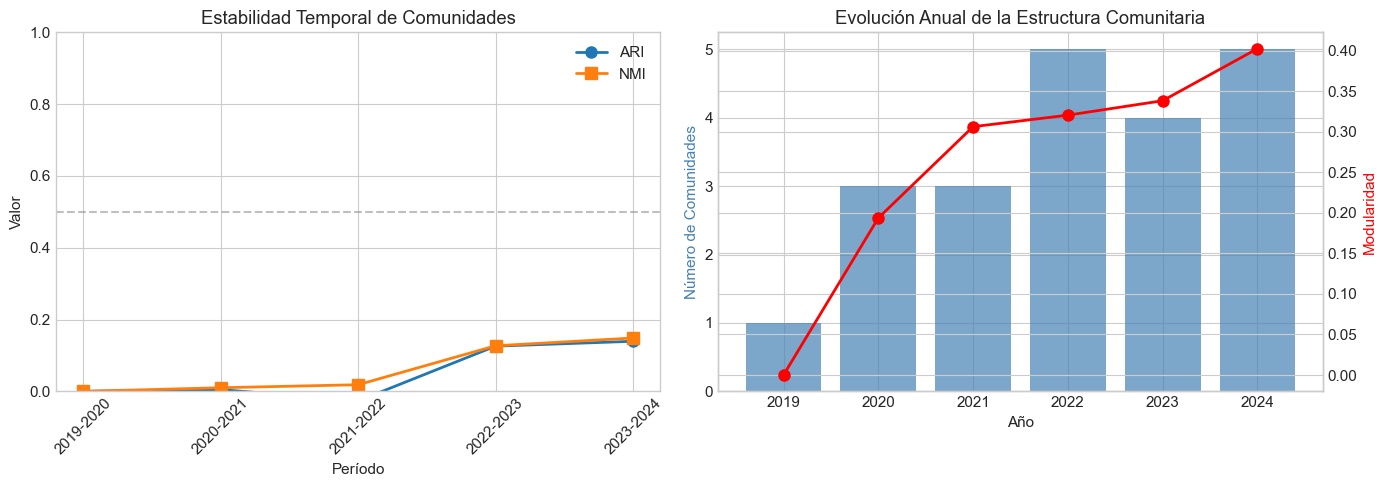

In [16]:
# Visualización de estabilidad temporal
if len(comparaciones_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de líneas ARI/NMI
    x = range(len(comparaciones_df))
    axes[0].plot(x, comparaciones_df['ARI'], 'o-', label='ARI', linewidth=2, markersize=8)
    axes[0].plot(x, comparaciones_df['NMI'], 's-', label='NMI', linewidth=2, markersize=8)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparaciones_df['Años'], rotation=45)
    axes[0].set_xlabel('Período')
    axes[0].set_ylabel('Valor')
    axes[0].set_title('Estabilidad Temporal de Comunidades')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Evolución de número de comunidades y modularidad
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    
    ax2.bar(redes_anuales_df['Año'].astype(str), redes_anuales_df['Comunidades'], 
            color='steelblue', alpha=0.7, label='Comunidades')
    ax2_twin.plot(redes_anuales_df['Año'].astype(str), redes_anuales_df['Modularidad'], 
                  'ro-', linewidth=2, markersize=8, label='Modularidad')
    
    ax2.set_xlabel('Año')
    ax2.set_ylabel('Número de Comunidades', color='steelblue')
    ax2_twin.set_ylabel('Modularidad', color='red')
    ax2.set_title('Evolución Anual de la Estructura Comunitaria')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/estabilidad_temporal.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No hay suficientes años para comparar")

In [17]:
# ============================================
# CARACTERIZACIÓN SEMÁNTICA DE REDES ANUALES
# ============================================

def caracterizar_comunidades_anual(df_datos, g_anio, membership, anio, atributos=['MODALIDAD', 'COMPLEJIDAD']):
    """
    Caracteriza las comunidades de un año específico con atributos semánticos.
    """
    # Filtrar datos del año
    df_anio = df_datos[df_datos['ANIO'] == anio].copy() if 'ANIO' in df_datos.columns else df_datos.copy()
    
    # Crear mapeo persona -> comunidad
    persona_comunidad = {name: com for name, com in zip(g_anio.vs['name'], membership)}
    
    # Agregar comunidad
    df_anio['comunidad'] = df_anio['PERSONA'].map(persona_comunidad)
    df_anio = df_anio.dropna(subset=['comunidad'])
    
    if len(df_anio) == 0:
        return pd.DataFrame()
    
    df_anio['comunidad'] = df_anio['comunidad'].astype(int)
    
    resultados = []
    for com_id in sorted(df_anio['comunidad'].unique()):
        df_com = df_anio[df_anio['comunidad'] == com_id]
        n_registros = len(df_com)
        n_personas = df_com['PERSONA'].nunique()
        
        fila = {
            'Año': anio,
            'Comunidad': com_id,
            'N_personas': n_personas,
            'N_registros': n_registros
        }
        
        for attr in atributos:
            if attr in df_com.columns:
                dist = df_com[attr].value_counts(normalize=True)
                if len(dist) > 0:
                    fila[f'{attr}_dominante'] = dist.idxmax()
                    fila[f'{attr}_prop'] = round(dist.max(), 3)
        
        resultados.append(fila)
    
    return pd.DataFrame(resultados)

# Caracterizar cada red anual
print("Calculando caracterización semántica por año...\n")
caracterizacion_anual_list = []

for anio in sorted(redes_anuales.keys()):
    g_anio = redes_anuales[anio]
    membership = comunidades_anuales[anio]['membership']
    
    caract_anio = caracterizar_comunidades_anual(datos_limpios, g_anio, membership, anio)
    if len(caract_anio) > 0:
        caracterizacion_anual_list.append(caract_anio)
        print(f"  {anio}: {len(caract_anio)} comunidades caracterizadas")

# Combinar todos los años
if caracterizacion_anual_list:
    caracterizacion_anual_df = pd.concat(caracterizacion_anual_list, ignore_index=True)
    print(f"\n=== CARACTERIZACIÓN SEMÁNTICA - REDES ANUALES ===")
    display(caracterizacion_anual_df)
else:
    caracterizacion_anual_df = pd.DataFrame()
    print("No se pudo caracterizar ningún año")

Calculando caracterización semántica por año...

  2019: 1 comunidades caracterizadas
  2020: 3 comunidades caracterizadas
  2021: 3 comunidades caracterizadas
  2022: 5 comunidades caracterizadas
  2023: 4 comunidades caracterizadas
  2024: 5 comunidades caracterizadas

=== CARACTERIZACIÓN SEMÁNTICA - REDES ANUALES ===
  2019: 1 comunidades caracterizadas
  2020: 3 comunidades caracterizadas
  2021: 3 comunidades caracterizadas
  2022: 5 comunidades caracterizadas
  2023: 4 comunidades caracterizadas
  2024: 5 comunidades caracterizadas

=== CARACTERIZACIÓN SEMÁNTICA - REDES ANUALES ===


,Año,Comunidad,N_personas,N_registros,MODALIDAD_dominante,MODALIDAD_prop,COMPLEJIDAD_dominante,COMPLEJIDAD_prop
0,2019,0,298,514,Presencial,0.765,Baja,0.837
1,2020,0,263,772,Virtual,0.584,Baja,0.737
2,2020,1,541,987,Virtual,0.821,Mediana,0.606
3,2020,2,2,2,Presencial,1.000,Mediana,1.000
4,2021,0,1378,1690,Virtual,0.827,Baja,0.837
5,2021,1,982,2213,Virtual,0.655,Baja,0.853
6,2021,2,26,33,Presencial,0.970,Mediana,0.939
7,2022,0,858,1581,Virtual,0.874,Baja,0.908
8,2022,1,549,1569,Presencial,0.679,Baja,0.672
9,2022,2,80,128,Presencial,0.883,Baja,0.797


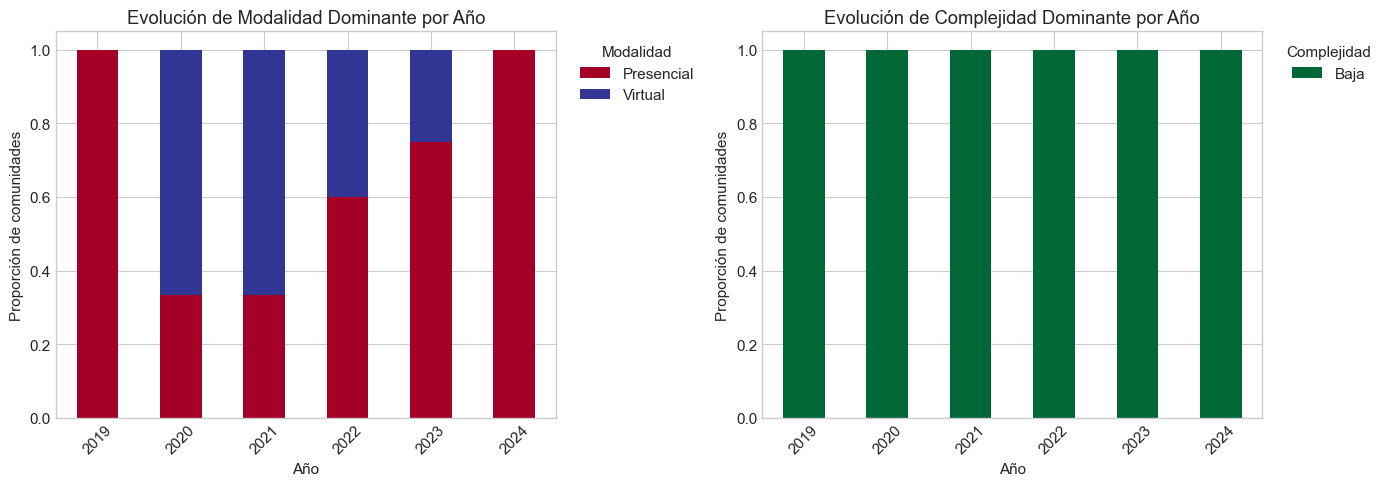


=== RESUMEN SEMÁNTICO POR AÑO ===


,N_comunidades,N_personas,N_registros,Modalidad_frecuente,Complejidad_frecuente
Año,,,,,
2019,1,298,514,Presencial,Baja
2020,3,806,1761,Virtual,Mediana
2021,3,2386,3936,Virtual,Baja
2022,5,1557,3360,Presencial,Baja
2023,4,711,2425,Presencial,Baja
2024,5,375,1345,Presencial,Baja


In [18]:
# ============================================
# VISUALIZACIÓN DE EVOLUCIÓN SEMÁNTICA TEMPORAL
# ============================================

if len(caracterizacion_anual_df) > 0 and 'MODALIDAD_dominante' in caracterizacion_anual_df.columns:
    # Resumen por año: proporción de comunidades por modalidad dominante
    resumen_modalidad = caracterizacion_anual_df.groupby(['Año', 'MODALIDAD_dominante']).size().unstack(fill_value=0)
    resumen_modalidad_norm = resumen_modalidad.div(resumen_modalidad.sum(axis=1), axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Evolución de modalidad dominante por año
    resumen_modalidad_norm.plot(kind='bar', stacked=True, ax=axes[0], colormap='RdYlBu')
    axes[0].set_xlabel('Año')
    axes[0].set_ylabel('Proporción de comunidades')
    axes[0].set_title('Evolución de Modalidad Dominante por Año')
    axes[0].legend(title='Modalidad', bbox_to_anchor=(1.02, 1))
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    
    # Evolución de complejidad dominante por año
    if 'COMPLEJIDAD_dominante' in caracterizacion_anual_df.columns:
        resumen_complejidad = caracterizacion_anual_df.groupby(['Año', 'COMPLEJIDAD_dominante']).size().unstack(fill_value=0)
        # Ordenar columnas
        orden_complejidad = ['Baja', 'Media', 'Alta']
        cols_existentes = [c for c in orden_complejidad if c in resumen_complejidad.columns]
        if cols_existentes:
            resumen_complejidad = resumen_complejidad[cols_existentes]
        resumen_complejidad_norm = resumen_complejidad.div(resumen_complejidad.sum(axis=1), axis=0)
        
        resumen_complejidad_norm.plot(kind='bar', stacked=True, ax=axes[1], colormap='RdYlGn_r')
        axes[1].set_xlabel('Año')
        axes[1].set_ylabel('Proporción de comunidades')
        axes[1].set_title('Evolución de Complejidad Dominante por Año')
        axes[1].legend(title='Complejidad', bbox_to_anchor=(1.02, 1))
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/caracterizacion_semantica_temporal.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Tabla resumen agregada por año
    print("\n=== RESUMEN SEMÁNTICO POR AÑO ===")
    resumen_anual = caracterizacion_anual_df.groupby('Año').agg({
        'Comunidad': 'count',
        'N_personas': 'sum',
        'N_registros': 'sum'
    }).rename(columns={'Comunidad': 'N_comunidades'})
    
    # Agregar modalidad y complejidad más frecuentes
    if 'MODALIDAD_dominante' in caracterizacion_anual_df.columns:
        modalidad_freq = caracterizacion_anual_df.groupby('Año')['MODALIDAD_dominante'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A')
        resumen_anual['Modalidad_frecuente'] = modalidad_freq
    
    if 'COMPLEJIDAD_dominante' in caracterizacion_anual_df.columns:
        complejidad_freq = caracterizacion_anual_df.groupby('Año')['COMPLEJIDAD_dominante'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A')
        resumen_anual['Complejidad_frecuente'] = complejidad_freq
    
    display(resumen_anual)
else:
    print("No hay datos suficientes para visualizar la evolución semántica temporal")

---
## 4. Estadísticas de Comunidades

Calculamos métricas internas para cada comunidad:
- Tamaño
- Densidad interna
- Grado promedio interno
- Coeficiente de clustering interno

In [19]:
def calcular_metricas_comunidad(g, membership, nombre_red=""):
    """
    Calcula métricas internas para cada comunidad.
    """
    comunidades = set(membership)
    metricas = []
    
    for com_id in sorted(comunidades):
        nodos_com = [i for i, m in enumerate(membership) if m == com_id]
        n_nodos = len(nodos_com)
        
        if n_nodos < 2:
            metricas.append({
                'Comunidad': com_id,
                'Tamaño': n_nodos,
                'Aristas_internas': 0,
                'Densidad': 0,
                'Grado_medio_interno': 0,
                'Clustering_interno': 0
            })
            continue
        
        subg = g.subgraph(nodos_com)
        n_aristas = subg.ecount()
        max_aristas = n_nodos * (n_nodos - 1) / 2
        densidad = n_aristas / max_aristas if max_aristas > 0 else 0
        grados = subg.degree()
        grado_medio = np.mean(grados) if grados else 0
        clustering = subg.transitivity_avglocal_undirected(mode='zero')
        
        metricas.append({
            'Comunidad': com_id,
            'Tamaño': n_nodos,
            'Aristas_internas': n_aristas,
            'Densidad': round(densidad, 4),
            'Grado_medio_interno': round(grado_medio, 2),
            'Clustering_interno': round(clustering, 4)
        })
    
    df = pd.DataFrame(metricas)
    df['Red'] = nombre_red
    return df

# ============================================
# MÉTRICAS POR COMUNIDAD - TODAS LAS REDES
# ============================================

print("Calculando métricas por comunidad para todas las redes...\n")

# Métricas para cada red
metricas_ponderada = calcular_metricas_comunidad(g_ponderada, louvain_ponderada.membership, "Ponderada")
metricas_binaria = calcular_metricas_comunidad(g_binaria, louvain_binaria.membership, "Binaria")
metricas_jaccard = calcular_metricas_comunidad(g_jaccard, louvain_jaccard.membership, "Jaccard")

# Para compatibilidad
metricas_comunidades = metricas_jaccard.copy()

# Mostrar cada una
print("="*60)
print("MÉTRICAS POR COMUNIDAD - RED PONDERADA")
print("="*60)
display(metricas_ponderada)

print("\n" + "="*60)
print("MÉTRICAS POR COMUNIDAD - RED BINARIA")
print("="*60)
display(metricas_binaria)

print("\n" + "="*60)
print("MÉTRICAS POR COMUNIDAD - RED JACCARD")
print("="*60)
display(metricas_jaccard)

Calculando métricas por comunidad para todas las redes...

MÉTRICAS POR COMUNIDAD - RED PONDERADA
MÉTRICAS POR COMUNIDAD - RED PONDERADA


,Comunidad,Tamaño,Aristas_internas,Densidad,Grado_medio_interno,Clustering_interno,Red
0,0,2285,2609470,1.0000,2284.00,1.0000,Ponderada
1,1,453,55773,0.5448,246.24,0.9703,Ponderada
2,2,2352,2764776,1.0000,2351.00,1.0000,Ponderada



MÉTRICAS POR COMUNIDAD - RED BINARIA


,Comunidad,Tamaño,Aristas_internas,Densidad,Grado_medio_interno,Clustering_interno,Red
0,0,2283,2604903,1.0000,2282.00,1.0000,Binaria
1,1,356,49878,0.7893,280.21,0.9725,Binaria
2,2,2352,2764776,1.0000,2351.00,1.0000,Binaria
3,3,99,4851,1.0000,98.00,1.0000,Binaria



MÉTRICAS POR COMUNIDAD - RED JACCARD


,Comunidad,Tamaño,Aristas_internas,Densidad,Grado_medio_interno,Clustering_interno,Red
0,0,2285,2609470,1.0000,2284.00,1.0000,Jaccard
1,1,453,55773,0.5448,246.24,0.9703,Jaccard
2,2,2352,2764776,1.0000,2351.00,1.0000,Jaccard



=== ESTADÍSTICAS AGREGADAS POR RED ===


,Red,N_comunidades,Tamaño_promedio,Tamaño_std,Densidad_promedio,Clustering_promedio
0,Ponderada,3,1696.7,1077.6,0.8483,0.9901
1,Binaria,4,1272.5,1211.5,0.9473,0.9931
2,Jaccard,3,1696.7,1077.6,0.8483,0.9901


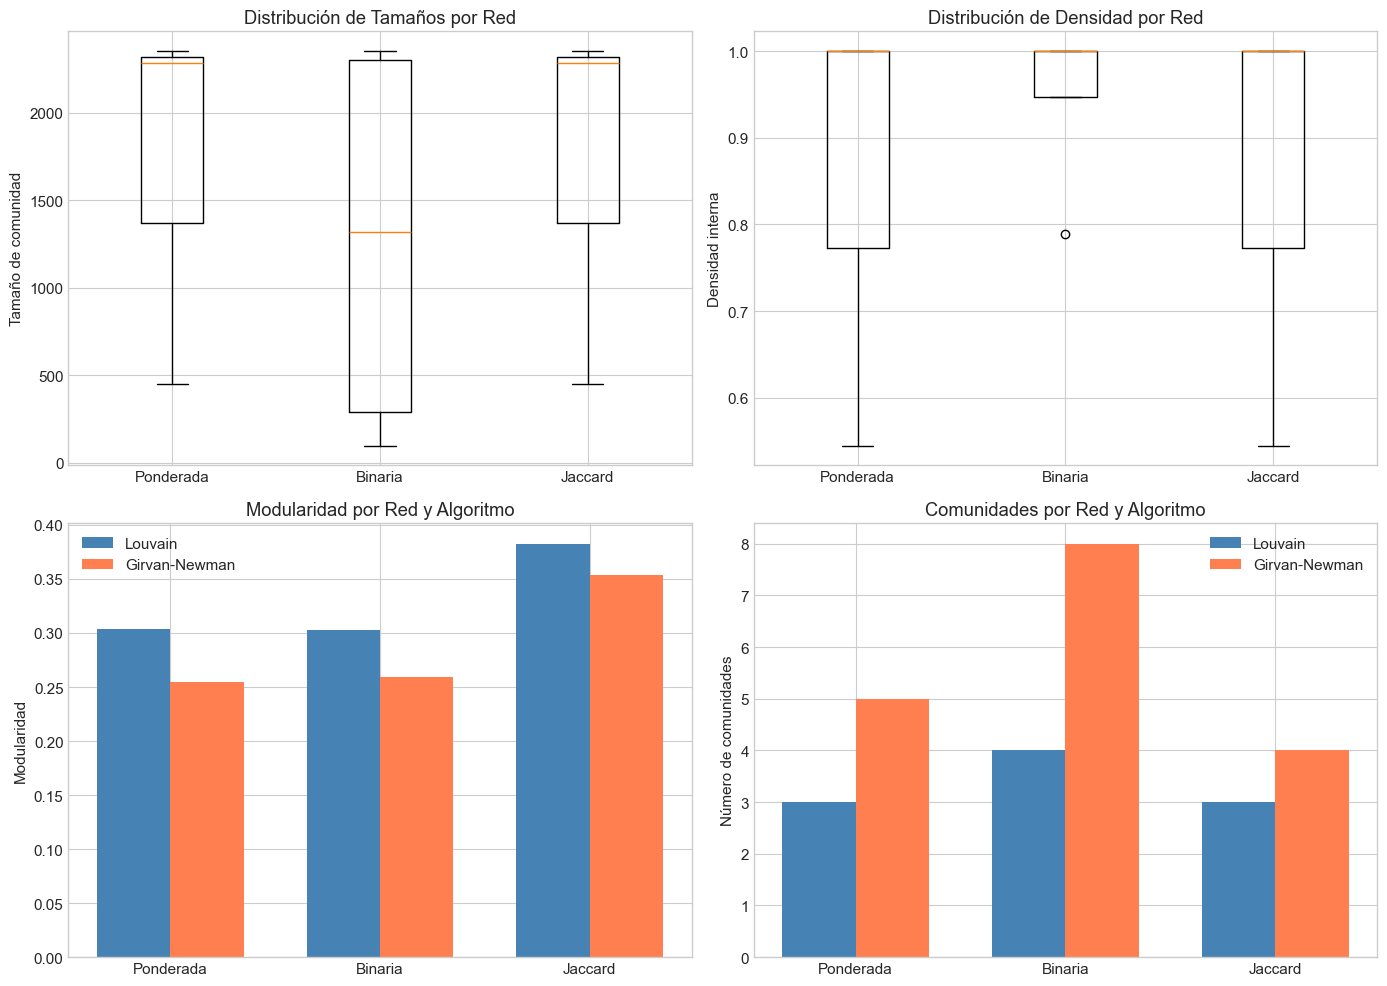

In [20]:
# ============================================
# ESTADÍSTICAS AGREGADAS - COMPARACIÓN ENTRE REDES
# ============================================

def resumir_metricas(df, nombre):
    return {
        'Red': nombre,
        'N_comunidades': len(df),
        'Tamaño_promedio': round(df['Tamaño'].mean(), 1),
        'Tamaño_std': round(df['Tamaño'].std(), 1),
        'Densidad_promedio': round(df['Densidad'].mean(), 4),
        'Clustering_promedio': round(df['Clustering_interno'].mean(), 4)
    }

resumen_metricas = pd.DataFrame([
    resumir_metricas(metricas_ponderada, 'Ponderada'),
    resumir_metricas(metricas_binaria, 'Binaria'),
    resumir_metricas(metricas_jaccard, 'Jaccard')
])

print("\n=== ESTADÍSTICAS AGREGADAS POR RED ===")
display(resumen_metricas)

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Combinar todas las métricas para visualización
todas_metricas = pd.concat([metricas_ponderada, metricas_binaria, metricas_jaccard])

# 1. Boxplot de Tamaño por Red
axes[0, 0].boxplot([metricas_ponderada['Tamaño'], metricas_binaria['Tamaño'], metricas_jaccard['Tamaño']],
                    labels=['Ponderada', 'Binaria', 'Jaccard'])
axes[0, 0].set_ylabel('Tamaño de comunidad')
axes[0, 0].set_title('Distribución de Tamaños por Red')

# 2. Boxplot de Densidad por Red
axes[0, 1].boxplot([metricas_ponderada['Densidad'], metricas_binaria['Densidad'], metricas_jaccard['Densidad']],
                    labels=['Ponderada', 'Binaria', 'Jaccard'])
axes[0, 1].set_ylabel('Densidad interna')
axes[0, 1].set_title('Distribución de Densidad por Red')

# 3. Barras de Modularidad por Red y Algoritmo
x = np.arange(3)
width = 0.35
rects1 = axes[1, 0].bar(x - width/2, [mod_ponderada, mod_binaria, mod_jaccard], width, label='Louvain', color='steelblue')
rects2 = axes[1, 0].bar(x + width/2, [mod_gn_ponderada, mod_gn_binaria, mod_gn_jaccard], width, label='Girvan-Newman', color='coral')
axes[1, 0].set_ylabel('Modularidad')
axes[1, 0].set_title('Modularidad por Red y Algoritmo')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Ponderada', 'Binaria', 'Jaccard'])
axes[1, 0].legend()

# 4. Número de comunidades por Red y Algoritmo
rects3 = axes[1, 1].bar(x - width/2, [n_com_ponderada, n_com_binaria, n_com_jaccard], width, label='Louvain', color='steelblue')
rects4 = axes[1, 1].bar(x + width/2, [n_gn_ponderada, n_gn_binaria, n_gn_jaccard], width, label='Girvan-Newman', color='coral')
axes[1, 1].set_ylabel('Número de comunidades')
axes[1, 1].set_title('Comunidades por Red y Algoritmo')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['Ponderada', 'Binaria', 'Jaccard'])
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/comparacion_redes_algoritmos.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Caracterización Semántica

Para cada comunidad, identificamos los atributos dominantes:
- **Modalidad** (Presencial/Virtual)
- **Complejidad** (Baja/Media/Alta)

Cruzamos la membresía de comunidad con los atributos de `datos_limpios.csv`.

In [21]:
# Crear mapeo persona -> comunidad
persona_comunidad = {name: com for name, com in zip(g_jaccard.vs['name'], louvain_result.membership)}

# Agregar comunidad a datos limpios
datos_con_comunidad = datos_limpios.copy()
datos_con_comunidad['comunidad'] = datos_con_comunidad['PERSONA'].map(persona_comunidad)

# Eliminar filas sin comunidad asignada (personas que no están en la red)
datos_con_comunidad = datos_con_comunidad.dropna(subset=['comunidad'])
datos_con_comunidad['comunidad'] = datos_con_comunidad['comunidad'].astype(int)

print(f"Registros con comunidad asignada: {len(datos_con_comunidad)} / {len(datos_limpios)}")
datos_con_comunidad.head()

Registros con comunidad asignada: 7955 / 7955


,AÑO,PERSONA,TIPO DE SERVICIO,NOMBRE DE LA TAREA,MODALIDAD,COMPLEJIDAD,comunidad
0,2019,Id_1,Serv_1,Tarea_1.1,Presencial,Baja,0
1,2019,Id_2,Serv_1,Tarea_1.1,Presencial,Baja,0
2,2019,Id_3,Serv_1,Tarea_1.1,Presencial,Baja,0
3,2019,Id_4,Serv_1,Tarea_1.1,Presencial,Baja,0
4,2019,Id_5,Serv_1,Tarea_1.1,Presencial,Baja,0


In [22]:
def caracterizar_comunidad(df, comunidad_col='comunidad', atributos=['MODALIDAD', 'COMPLEJIDAD']):
    """
    Calcula la distribución de atributos por comunidad y determina el valor dominante.
    """
    resultados = []
    
    for com_id in sorted(df[comunidad_col].unique()):
        df_com = df[df[comunidad_col] == com_id]
        n_registros = len(df_com)
        n_personas = df_com['PERSONA'].nunique()
        
        fila = {
            'Comunidad': com_id,
            'N_registros': n_registros,
            'N_personas': n_personas
        }
        
        for attr in atributos:
            if attr in df_com.columns:
                # Distribución
                dist = df_com[attr].value_counts(normalize=True)
                # Valor dominante
                dominante = dist.idxmax()
                prop_dominante = dist.max()
                
                fila[f'{attr}_dominante'] = dominante
                fila[f'{attr}_prop'] = round(prop_dominante, 3)
        
        resultados.append(fila)
    
    return pd.DataFrame(resultados)

# Caracterizar comunidades
caracterizacion = caracterizar_comunidad(datos_con_comunidad)

print("\n=== CARACTERIZACIÓN SEMÁNTICA DE COMUNIDADES ===")
caracterizacion


=== CARACTERIZACIÓN SEMÁNTICA DE COMUNIDADES ===


,Comunidad,N_registros,N_personas,MODALIDAD_dominante,MODALIDAD_prop,COMPLEJIDAD_dominante,COMPLEJIDAD_prop
0,0,3728,2285,Virtual,0.736,Baja,0.910
1,1,1321,453,Presencial,0.794,Baja,0.543
2,2,2906,2352,Virtual,0.549,Baja,0.569


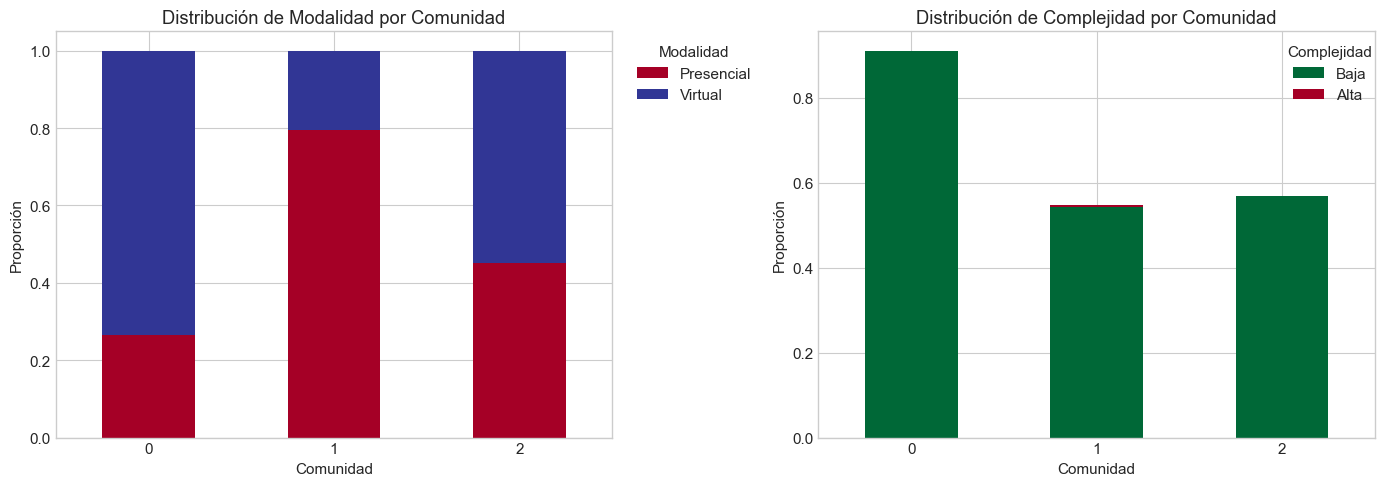

In [23]:
# Visualización de caracterización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de Modalidad por comunidad
modalidad_pivot = datos_con_comunidad.groupby(['comunidad', 'MODALIDAD']).size().unstack(fill_value=0)
modalidad_norm = modalidad_pivot.div(modalidad_pivot.sum(axis=1), axis=0)

modalidad_norm.plot(kind='bar', stacked=True, ax=axes[0], colormap='RdYlBu')
axes[0].set_xlabel('Comunidad')
axes[0].set_ylabel('Proporción')
axes[0].set_title('Distribución de Modalidad por Comunidad')
axes[0].legend(title='Modalidad', bbox_to_anchor=(1.02, 1))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Distribución de Complejidad por comunidad
complejidad_pivot = datos_con_comunidad.groupby(['comunidad', 'COMPLEJIDAD']).size().unstack(fill_value=0)
complejidad_norm = complejidad_pivot.div(complejidad_pivot.sum(axis=1), axis=0)

# Ordenar columnas si existen
orden_complejidad = ['Baja', 'Media', 'Alta']
cols_existentes = [c for c in orden_complejidad if c in complejidad_norm.columns]
if cols_existentes:
    complejidad_norm = complejidad_norm[cols_existentes]

complejidad_norm.plot(kind='bar', stacked=True, ax=axes[1], colormap='RdYlGn_r')
axes[1].set_xlabel('Comunidad')
axes[1].set_ylabel('Proporción')
axes[1].set_title('Distribución de Complejidad por Comunidad')
axes[1].legend(title='Complejidad', bbox_to_anchor=(1.02, 1))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../reports/figures/caracterizacion_semantica.png', dpi=150, bbox_inches='tight')
plt.show()

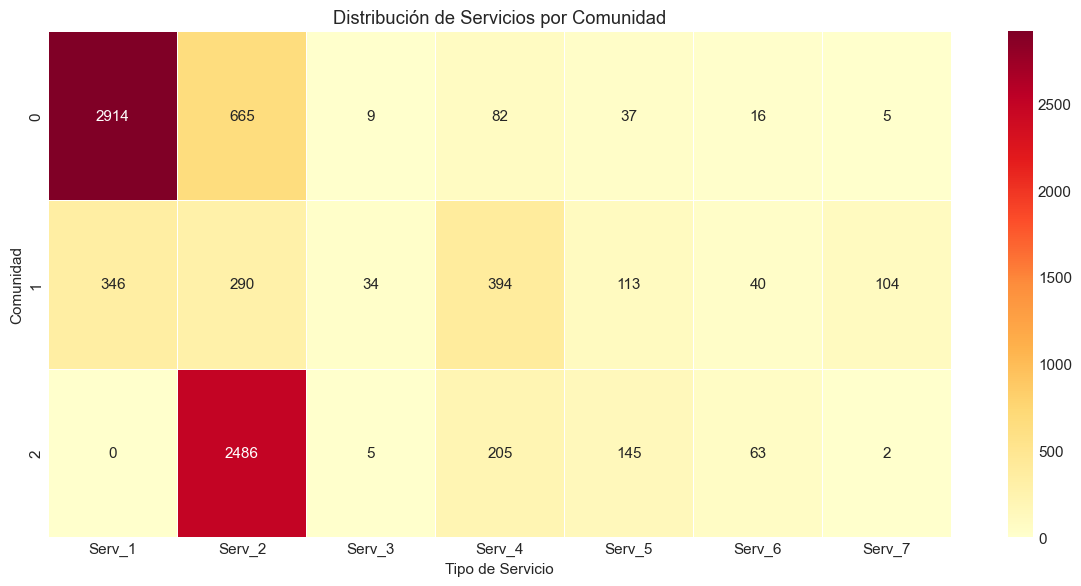

In [24]:
# Heatmap de servicios por comunidad
servicios_comunidad = datos_con_comunidad.groupby(['comunidad', 'TIPO DE SERVICIO']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(servicios_comunidad, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
plt.title('Distribución de Servicios por Comunidad')
plt.xlabel('Tipo de Servicio')
plt.ylabel('Comunidad')
plt.tight_layout()
plt.savefig('../reports/figures/heatmap_servicios_comunidad.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Resumen para el Informe

In [25]:
# Tabla resumen final
resumen_final = caracterizacion.merge(metricas_comunidades, on='Comunidad', how='left')

# Reordenar columnas
cols_orden = ['Comunidad', 'Tamaño', 'N_personas', 'N_registros', 'Densidad', 
              'Clustering_interno', 'MODALIDAD_dominante', 'MODALIDAD_prop',
              'COMPLEJIDAD_dominante', 'COMPLEJIDAD_prop']
cols_existentes = [c for c in cols_orden if c in resumen_final.columns]
resumen_final = resumen_final[cols_existentes]

print("\n" + "="*80)
print("TABLA RESUMEN FINAL: COMUNIDADES DETECTADAS")
print("="*80)
resumen_final


TABLA RESUMEN FINAL: COMUNIDADES DETECTADAS


,Comunidad,Tamaño,N_personas,N_registros,Densidad,Clustering_interno,MODALIDAD_dominante,MODALIDAD_prop,COMPLEJIDAD_dominante,COMPLEJIDAD_prop
0,0,2285,2285,3728,1.0000,1.0000,Virtual,0.736,Baja,0.910
1,1,453,453,1321,0.5448,0.9703,Presencial,0.794,Baja,0.543
2,2,2352,2352,2906,1.0000,1.0000,Virtual,0.549,Baja,0.569


In [26]:
# Guardar tabla resumen
resumen_final.to_csv('../reports/comunidades_resumen.csv', index=False)
print("\n✓ Tabla guardada en reports/comunidades_resumen.csv")


✓ Tabla guardada en reports/comunidades_resumen.csv


In [27]:
# Resumen ejecutivo
print("\n" + "="*80)
print("RESUMEN EJECUTIVO")
print("="*80)

# Calcular métricas temporales
if len(comparaciones_df) > 0:
    ari_promedio = f"{comparaciones_df['ARI'].mean():.4f}"
    nmi_promedio = f"{comparaciones_df['NMI'].mean():.4f}"
    interpretacion = 'Alta estabilidad temporal' if comparaciones_df['ARI'].mean() > 0.5 else 'Estructura cambiante'
else:
    ari_promedio = 'N/A'
    nmi_promedio = 'N/A'
    interpretacion = 'N/A'

print(f"""
RED ANALIZADA:
- Tipo: Proyección unimodal de clientes conectados por servicios compartidos
- Variante principal: Jaccard (normalizada por tamaño de portfolio)
- Nodos (clientes): {g_jaccard.vcount()}
- Aristas (conexiones): {g_jaccard.ecount()}

DETECCIÓN DE COMUNIDADES (Louvain):
- Número de comunidades: {n_comunidades}
- Modularidad: {modularidad:.4f}
- Tamaño promedio: {metricas_comunidades['Tamaño'].mean():.1f} clientes
- Densidad interna promedio: {metricas_comunidades['Densidad'].mean():.4f}

ANÁLISIS TEMPORAL ({len(anios_ordenados)} años: {min(anios_ordenados)}-{max(anios_ordenados)}):
- ARI promedio entre años consecutivos: {ari_promedio}
- NMI promedio entre años consecutivos: {nmi_promedio}
- Interpretación: {interpretacion}

CARACTERIZACIÓN SEMÁNTICA:
- Las comunidades muestran patrones diferenciados en Modalidad y Complejidad
- Ver tabla resumen_final para detalles por comunidad
""")


RESUMEN EJECUTIVO

RED ANALIZADA:
- Tipo: Proyección unimodal de clientes conectados por servicios compartidos
- Variante principal: Jaccard (normalizada por tamaño de portfolio)
- Nodos (clientes): 5090
- Aristas (conexiones): 7189307

DETECCIÓN DE COMUNIDADES (Louvain):
- Número de comunidades: 3
- Modularidad: 0.3826
- Tamaño promedio: 1696.7 clientes
- Densidad interna promedio: 0.8483

ANÁLISIS TEMPORAL (6 años: 2019-2024):
- ARI promedio entre años consecutivos: 0.0487
- NMI promedio entre años consecutivos: 0.0608
- Interpretación: Estructura cambiante

CARACTERIZACIÓN SEMÁNTICA:
- Las comunidades muestran patrones diferenciados en Modalidad y Complejidad
- Ver tabla resumen_final para detalles por comunidad



In [28]:
# Limitaciones y trabajo futuro
print("\n" + "="*80)
print("LIMITACIONES Y TRABAJO FUTURO")
print("="*80)

print("""
1. LIMITACIONES DEL ANÁLISIS ACTUAL:
   - Jaccard calculado sobre toda la ventana temporal (no por año)
   - Girvan-Newman aplicado solo a subgrafo por costo computacional
   - No se realizó análisis pre/post pandemia explícito

2. EXTENSIONES POSIBLES:
   - Calcular peso Jaccard por año para análisis temporal más fino
   - Implementar otros algoritmos (Infomap, Label Propagation)
   - Análisis de centralidad por comunidad
   - Detección de comunidades solapantes (overlapping communities)
   - Análisis de la evolución de clientes individuales entre comunidades

3. FIGURAS GENERADAS:
   - reports/figures/comunidades_louvain_distribucion.png
   - reports/figures/estabilidad_temporal.png
   - reports/figures/metricas_comunidades.png
   - reports/figures/caracterizacion_semantica.png
   - reports/figures/heatmap_servicios_comunidad.png
""")


LIMITACIONES Y TRABAJO FUTURO

1. LIMITACIONES DEL ANÁLISIS ACTUAL:
   - Jaccard calculado sobre toda la ventana temporal (no por año)
   - Girvan-Newman aplicado solo a subgrafo por costo computacional
   - No se realizó análisis pre/post pandemia explícito

2. EXTENSIONES POSIBLES:
   - Calcular peso Jaccard por año para análisis temporal más fino
   - Implementar otros algoritmos (Infomap, Label Propagation)
   - Análisis de centralidad por comunidad
   - Detección de comunidades solapantes (overlapping communities)
   - Análisis de la evolución de clientes individuales entre comunidades

3. FIGURAS GENERADAS:
   - reports/figures/comunidades_louvain_distribucion.png
   - reports/figures/estabilidad_temporal.png
   - reports/figures/metricas_comunidades.png
   - reports/figures/caracterizacion_semantica.png
   - reports/figures/heatmap_servicios_comunidad.png



---
## Fin del Análisis

Este notebook implementa el análisis completo de comunidades para el trabajo final de Redes Complejas.

**Archivos generados:**
- `reports/comunidades_resumen.csv` – Tabla resumen de comunidades
- `reports/figures/*.png` – Visualizaciones